# Graph classification.
Vediamo come applicare le Graph Neural Network (GNN) per il task di classificazione. Dato un dataset di grafi con determinate caratteristiche strutturali, facciamo l'embedding di un intero grafo. Successivamente effettuiamo una classificazione dei grafi.

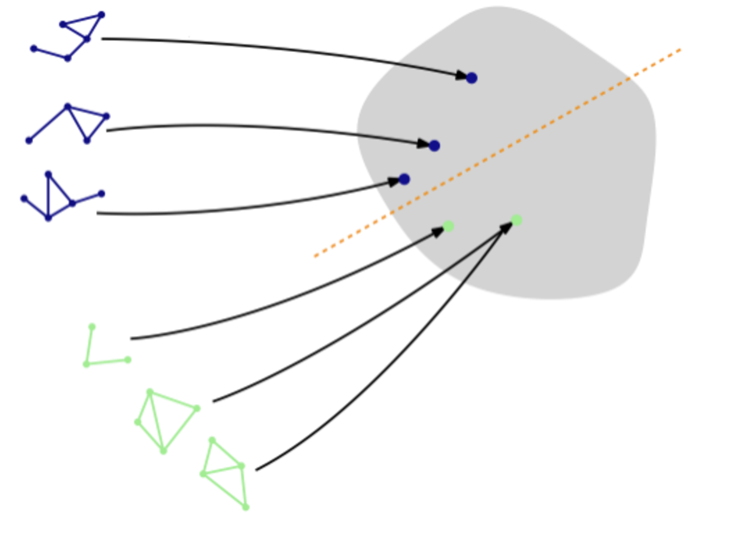


In [1]:
import torch
from torch_geometric.datasets import TUDataset
import torch_geometric.transforms as T



transform = T.Compose([T.ToUndirected(), T.AddSelfLoops()])

#dataset = TUDataset(path, name='MUTAG', transform=transform)

dataset = TUDataset(root='data1/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Numero di grafi: {len(dataset)}')
print(f'Numero di feature: {dataset.num_features}')
print(f'Numero di classi: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Numero di nodi: {data.num_nodes}')
print(f'Numero di archi: {data.num_edges}')
print(f'Grado medio dei nodi: {data.num_edges / data.num_nodes:.2f}')
print(f'Ci sono nodi isolati: {data.has_isolated_nodes()}')
print(f'Ci sono self loop: {data.has_self_loops()}')
print(f'E\' non direzionato: {data.is_undirected()}')


Dataset: MUTAG(188):
Numero di grafi: 188
Numero di feature: 7
Numero di classi: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Numero di nodi: 17
Numero di archi: 38
Grado medio dei nodi: 2.24
Ci sono nodi isolati: False
Ci sono self loop: False
E' non direzionato: True


## MUTAG 
Il dataset MUTAG dataset contiene 188 compound chimici divisi in due classi in base al loro effetto mutagenico su un batterio. 

Il dato chimico è stato ottenuto da http://cdb.ics.uci.edu e convertito in grafi dove i vertici rappresentano gli atomi e gli archi rappresentano i legami chimici. Gli atomi di itrogeno espliciti sono stati rimossi e i vertici sono etichettati  dai tipi di aotmi  gli archi dal tipo di legame (single, double, triple o aromatic).


In [2]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Numero di grafi nel training set: {len(train_dataset)}')
print(f'Numero di grafi nel test set : {len(test_dataset)}')

Numero di grafi nel training set: 150
Numero di grafi nel test set : 38


In [3]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Numero di grafi nel batch corrente: {data.num_graphs}')
    print(data)
    print()

Step 1:
Numero di grafi nel batch corrente: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Numero di grafi nel batch corrente: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Numero di grafi nel batch corrente: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



In [20]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import SAGEConv



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        #self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels,aggr="max")
        self.conv2 = SAGEConv(hidden_channels, hidden_channels,aggr="max")
        self.conv3 = SAGEConv(hidden_channels, hidden_channels,aggr="max")
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Embedding dei nodi 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2.  pooling
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. classificazione lineare
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        #print(x.shape)
        #print(dataset.num_node)
        
        return x

model = GCN(hidden_channels=128)
print(model)

GCN(
  (conv1): SAGEConv(7, 128, aggr=max)
  (conv2): SAGEConv(128, 128, aggr=max)
  (conv3): SAGEConv(128, 128, aggr=max)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


In [22]:
model = GCN(hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iteriamo nei batch sui dati di training 
         out = model(data.x, data.edge_index, data.batch)  # foward
         loss = criterion(out, data.y)  # loss.
         loss.backward()  # gradiente.
         optimizer.step()  # Update parametri in base al gradiente.
         optimizer.zero_grad()  # azzeriamo il gradiente
         return loss

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iteriamo nei batch sui dati di training/testing.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # selezioniamo la classe con la piu' alta probaiblità.
         correct += int((pred == data.y).sum())  # verifica della corretteza.
     return correct / len(loader.dataset)  # percentuale di correttezza.


for epoch in range(1, 201):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Loss: {loss:.4f}')

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6835
Epoch: 002, Train Acc: 0.3533, Test Acc: 0.2632, Loss: 0.7663
Epoch: 003, Train Acc: 0.3533, Test Acc: 0.2632, Loss: 2.9455
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.9112
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6732
Epoch: 006, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6472
Epoch: 007, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.7086
Epoch: 008, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6126
Epoch: 009, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6136
Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6231
Epoch: 011, Train Acc: 0.6533, Test Acc: 0.7368, Loss: 0.6360
Epoch: 012, Train Acc: 0.6667, Test Acc: 0.7368, Loss: 0.6004
Epoch: 013, Train Acc: 0.6933, Test Acc: 0.7895, Loss: 0.6093
Epoch: 014, Train Acc: 0.7067, Test Acc: 0.8158, Loss: 0.6546
Epoch: 015, Train Acc: 0.7067, Test Acc: 0.8158, Loss: 0.6106
Epoch: 016, Train Acc: 0.7267, Test Acc: 0.8158, Loss: 0.5430
Epoch: 0

In [23]:
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels,aggr="mean")
        self.conv2 = GraphConv(hidden_channels, hidden_channels,aggr="mean")
        self.conv3 = GraphConv(hidden_channels, hidden_channels,aggr="mean")
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GNN(hidden_channels=128)
print(model)

GNN(
  (conv1): GraphConv(7, 128)
  (conv2): GraphConv(128, 128)
  (conv3): GraphConv(128, 128)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


In [24]:
#model = GNN(hidden_channels=64)
#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Loss: {loss:.4f}')

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6853
Epoch: 002, Train Acc: 0.3533, Test Acc: 0.2632, Loss: 0.9058
Epoch: 003, Train Acc: 0.3533, Test Acc: 0.2632, Loss: 1.6708
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.7862
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6752
Epoch: 006, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6534
Epoch: 007, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6916
Epoch: 008, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6264
Epoch: 009, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6231
Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6404
Epoch: 011, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6700
Epoch: 012, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6189
Epoch: 013, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6567
Epoch: 014, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6984
Epoch: 015, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6417
Epoch: 016, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6305
Epoch: 0

In [42]:
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, global_max_pool,global_add_pool,SAGPooling,TopKPooling

class GlobalPoolingLayer(nn.Module):
    """
    Implementazione di diversi tipi di global pooling
    """
    def __init__(self, pooling_type='mean'):
        super().__init__()
        self.pooling_type = pooling_type
    
    def forward(self, x, batch):
        """
        Args:
            x: features dei nodi [num_nodes, feature_dim]
            batch: tensor che indica a quale grafo appartiene ogni nodo
        """
        if self.pooling_type == 'mean':
            return global_mean_pool(x, batch)
        elif self.pooling_type == 'max':
            return global_max_pool(x, batch)
        elif self.pooling_type == 'sum':
            return global_add_pool(x, batch)
        elif self.pooling_type == 'attention':
            # Implementazione semplificata di attention pooling
            attention_weights = torch.softmax(x.mean(dim=1, keepdim=True), dim=0)
            return global_add_pool(x * attention_weights, batch)
        else:
            raise ValueError(f"Pooling type {self.pooling_type} non supportato")


Quando i grafi sono grandi o hanno una struttura complessa, è utile ridurre progressivamente la dimensione del grafo mantenendo la sua topologia. PyTorch Geometric offre vari metodi:

In [48]:
class HierarchicalGraphClassifier(nn.Module):
    """
    Classificatore con pooling gerarchico
    """
    def __init__(self, input_dim, hidden_dim=64, embedding_dim=32, num_classes=2, 
                 pooling_type='sag', pooling_ratio=0.8):
        super().__init__()

        torch.manual_seed(12345)

        # Prima fase di convoluzione
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # Primo pooling gerarchico
        if pooling_type == 'sag':
            self.pool1 = SAGPooling(hidden_dim, ratio=pooling_ratio)
        elif pooling_type == 'topk':
            self.pool1 = TopKPooling(hidden_dim, ratio=pooling_ratio)
        
        # Seconda fase di convoluzione
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, embedding_dim)
        
        # Pooling globale finale
        self.global_pool = GlobalPoolingLayer('max')
        
        # Classificatore
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        self.pooling_type = f"hierarchical_{pooling_type}"
    
    def forward(self, x, edge_index, batch):
        #x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Prima fase di convoluzione
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        # Primo pooling gerarchico
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, batch=batch)
        
        # Seconda fase di convoluzione
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        
        # Pooling globale finale
        embedding = self.global_pool(x, batch)
        
        #if return_embedding:
        #    return embedding
        
        # Classificazione
        logits = self.classifier(embedding)
        
        return logits


# Esercizi:
1. Usare il primo modello con GraphSAGE
2. Partendo dal modello che usa il pooling gerarchio, modificare il primo modello e rifare la classificazione

In [49]:
model = HierarchicalGraphClassifier(input_dim=7, pooling_type='topk')
#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iteriamo nei batch sui dati di training 
         out = model(data.x, data.edge_index, data.batch)  # foward
         loss = criterion(out, data.y)  # loss.
         loss.backward()  # gradiente.
         optimizer.step()  # Update parametri in base al gradiente.
         optimizer.zero_grad()  # azzeriamo il gradiente
         return loss

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iteriamo nei batch sui dati di training/testing.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # selezioniamo la classe con la piu' alta probaiblità.
         correct += int((pred == data.y).sum())  # verifica della corretteza.
     return correct / len(loader.dataset)  # percentuale di correttezza.




for epoch in range(1, 201):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Loss: {loss:.4f}')

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6966
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6920
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6837
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6617
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.7016
Epoch: 006, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6043
Epoch: 007, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6100
Epoch: 008, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6324
Epoch: 009, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.7454
Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6336
Epoch: 011, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6851
Epoch: 012, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6504
Epoch: 013, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6434
Epoch: 014, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6440
Epoch: 015, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6579
Epoch: 016, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6587
Epoch: 0